<font color='blue'> **01a - Freyberg (1988) - Steady State** </font> 

In [1]:
import os ; import pathlib as pl ; import pandas as pd                  ; import numpy as np ;  import matplotlib.pyplot as plt 
from pathlib import Path         ; from flopy.plot.styles import styles ; import sys  ; import matplotlib as mpl ; import flopy 
from modflow_devtools.misc import get_env, timed ; write=get_env("WRITE", True);run=get_env("RUN", True) 
sim_ws   = Path("./01a") ; sim_ws.mkdir(exist_ok=True)          ; sim_name = "Freyberg"

In [2]:
path   = 'E:\\15_REPOS\\00_BETAMI\\95_Freyberg\\00\\01a' ; #path   = 'E:\\15_REPOS\\00_BETAMI\\bin\\data_modflow6-examples\\ex-gwf-capture' 
fpath1 = os.path.join(path,"bottom.txt")                 ; bottom  = np.loadtxt(fpath1)
fpath2 = os.path.join(path,"hydraulic_conductivity.txt") ; k11     = np.loadtxt(fpath2)
fpath3 = os.path.join(path,"idomain.txt")                ; idomain = np.loadtxt(fpath3, dtype=np.int32)

In [3]:
length_units="meters" ;nlay=1;nrow=40;ncol=20;delr=250.0;delc=250.0      ;top=35.0;icelltype=1;strt=45.0;
time_units="seconds"  ;recharge=1.60000000e-09     ; nouter=100;ninner=25;hclose=1e-9;rclose=1e-3       ; nper=1; tdis_ds=((1.0,1.0,1),)
wel_spd = {0: [[0,  8, 15, -0.00820000]     ,[0, 10, 12, -0.00410000] ,[0, 19, 13, -0.00390000] ,[0, 25, 9, -8.30000000e-04],
               [0, 28,  5, -7.20000000e-04] ,[0, 33, 11, -0.00430000]]}
chd_spd = {0: [[0, 39,  5, 16.90000000]     ,[0, 39,  6, 16.40000000] ,[0, 39,  7, 16.10000000] ,[0, 39,  8, 15.60000000]   ,[0, 39,  9, 15.10000000],
               [0, 39, 10, 14.00000000]     ,[0, 39, 11, 13.00000000] ,[0, 39, 12, 12.50000000] ,[0, 39, 13, 12.00000000]   ,[0, 39, 14, 11.40000000]]}
rbot = np.linspace(20.0, 10.25, num=nrow)      ; rstage = np.linspace(20.1, 11.25, num=nrow)   ; riv_spd = []
for idx, (s, b) in enumerate(zip(rstage, rbot)): riv_spd.append([0, idx, 14, s, 0.05, b]) 
riv_spd = {0: riv_spd}

In [4]:
def build_models():
    sim = flopy.mf6.MFSimulation   (sim_name=sim_name,sim_ws=sim_ws,exe_name="mf6",)
    flopy.mf6.ModflowTdis    (sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms     (sim,linear_acceleration="BICGSTAB",outer_maximum=nouter,outer_dvclose=hclose * 10.0,inner_maximum=ninner,
                              inner_dvclose=hclose,rcloserecord=f"{rclose} strict")
    gwf = flopy.mf6.ModflowGwf     (sim,modelname=sim_name,newtonoptions="NEWTON UNDER_RELAXATION")
    flopy.mf6.ModflowGwfdis  (gwf,length_units=length_units,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,top=top,botm=bottom,idomain=idomain)
    flopy.mf6.ModflowGwfnpf  (gwf,icelltype=icelltype,k=k11,)
    flopy.mf6.ModflowGwfic   (gwf, strt=strt)
    flopy.mf6.ModflowGwfriv  (gwf, stress_period_data = riv_spd, pname="RIV-1")
    flopy.mf6.ModflowGwfwel  (gwf, stress_period_data = wel_spd, pname="WEL-1")
    flopy.mf6.ModflowGwfrcha (gwf, recharge=recharge)
    flopy.mf6.ModflowGwfchd  (gwf, stress_period_data = chd_spd)                                                     # ; bf=f"{sim_name}.cbc"
    flopy.mf6.ModflowGwfwel  (gwf,maxbound=1,pname="CF-1",filename=f"{sim_name}.cf.wel")        ; hf=f"{sim_name}.hds" ; bf=f"{sim_name}.bud"
    flopy.mf6.ModflowGwfoc   (gwf ,head_filerecord=hf,budget_filerecord=bf,headprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
                             saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")] ,printrecord=[("HEAD", "ALL"), ("BUDGET", "ALL")])  
    return sim
def write_models(sim, silent=True): sim.write_simulation(silent=silent)
@timed
def run_models(sim, silent=True):   success, buff = sim.run_simulation(silent=silent)  ; assert success, buff
def scenario(silent=True):
    sim = build_models()
    if write:  write_models(sim, silent=silent)
    if run:    run_models  (sim, silent=silent)
scenario()

run_models took 201.68 ms


In [5]:
sim = build_models() ; gwf = sim.get_model(sim_name) ; heads = gwf.output.head()  ;hds = gwf.output.head() ; head = hds.get_alldata()[0] 

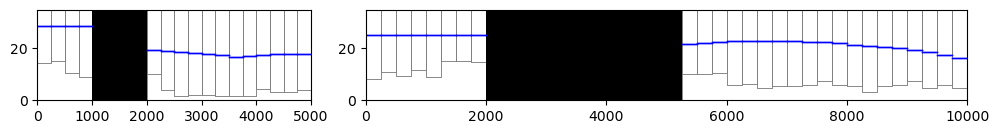

In [6]:
from flopy.utils.postprocessing import get_water_table ; wt = get_water_table(head)
irow, icol = gwf.modelgrid.intersect(1700, 6000)  
def beta_plot(ax):
    pmv=flopy.plot.PlotCrossSection(model=gwf,ax=ax2, line={"column": icol}) ; pmv.plot_grid(linewidth=0.5) ; pmv.plot_inactive()
    pmv.plot_surface(wt, masked_values=[1e30], color="blue", lw=1) 
    pmv=flopy.plot.PlotCrossSection(model=gwf,ax=ax1,line={"row": irow})     ; pmv.plot_grid(linewidth=0.5) ; pmv.plot_inactive()
    pmv.plot_surface(wt, masked_values=[1e30], color="blue", lw=1) 
plt.figure(figsize=(12,4))
ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=1, rowspan=1)  ;   
ax2 = plt.subplot2grid((3, 3), (0, 1), colspan=2, rowspan=1)  ; beta_plot(ax1) ; beta_plot(ax2) 

In [7]:
sim = build_models() ; gwf = sim.get_model(sim_name) ; hds = gwf.output.head() ; head = hds.get_alldata()[0]   ; wel = gwf.get_package("WEL-1")
sat_thk = gwf.modelgrid.saturated_thickness(head, mask=[1e30])  ; thk = gwf.modelgrid.cell_thickness ; modelgrid = gwf.modelgrid 

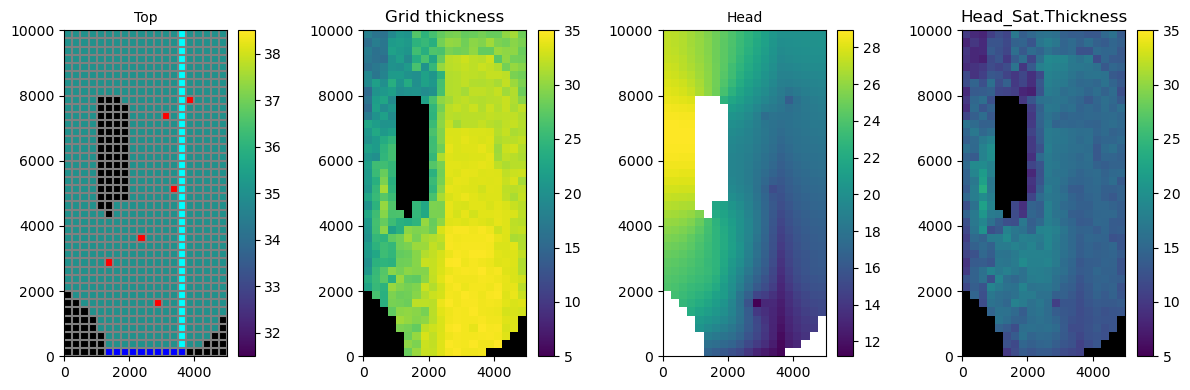

In [8]:
fig = plt.figure(figsize=(12, 4))                       
ax1 = fig.add_subplot(141, aspect="equal") 
mm = flopy.plot.PlotMapView(model=gwf, layer=0, extent=gwf.modelgrid.extent)  ; cbv = mm.plot_array([modelgrid.top]) ; cb = plt.colorbar(cbv,ax=mm.ax)
mm.plot_bc(package=wel)   ; mm.plot_bc("RIV", color="cyan")                   ; mm.plot_bc("CHD", color="green"); mm.plot_ibound()
mm.plot_grid()            ; mm.plot_bc(name="CHD",color="blue" )              ; ax1.set_title("Top", fontsize=10)
ax2 = fig.add_subplot(142, aspect="equal") 
pmv = flopy.plot.PlotMapView(modelgrid=gwf.modelgrid) ; pc1 = pmv.plot_array(thk, vmin=5, vmax=35) ; pmv.plot_ibound() 
plt.colorbar(pc1)                       ; ax2.set_title("Grid thickness") 
ax3 = fig.add_subplot(143, aspect="equal") ; mm = flopy.plot.PlotMapView(model=gwf, layer=0, extent=gwf.modelgrid.extent)  
cbv = mm.plot_array(head) ;   cb = plt.colorbar(cbv, ax=mm.ax, shrink=1)      ; ax3.set_title("Head", fontsize=10)
ax4 = fig.add_subplot(144, aspect="equal") 
pmv = flopy.plot.PlotMapView(modelgrid=gwf.modelgrid) ; pc2 = pmv.plot_array(sat_thk, vmin=5, vmax=35)
pmv.plot_ibound() ; ax4.set_title("Head_Sat.Thickness") ; plt.tight_layout() ; plt.colorbar(pc2)
plt.show()